<img src="img\Ines_Logo_blau_dt.jpg" width="300"/>

In [1]:
import sys
import os
from pathlib import Path

sys.path.append(f'{Path(sys.path[0]).parents[1]}')
sys.path.append('../')

In [2]:
import os
import pandas as pd
import seaborn as sns
from glob import glob
import numpy as np
import datetime as dt

# plots
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec

from SME_LIB.sme import SME

import gurobipy as gb

#MFS Formulation
from cs.opt_formulations_mpc.mfs_opt_formulation import mfs_opt_formulation
from cs.opt_formulations_mpc.mfs_opt_formulation import mfs_opt_formulation_scheduling

#Import MPC Formulation(CAS;PCS:PHS)
from cs.opt_formulations_mpc.cas_formulation import cas_opt_formulation_mpc
from cs.opt_formulations_mpc.phs_formulation import phs_opt_formulation_energy_based_mpc
from cs.opt_formulations_mpc.pcs_formulation import pcs_opt_formulation_mpc
from cs.opt_formulations_mpc.hvac_formulation import hvac_opt_formulation_mpc
from cs.opt_formulations_mpc.es_formulation import es_pv_opt_formulation_mpc
#Battery Formulation
from cs.opt_formulations_mpc.es_formulation import es_bess_opt_formulation_mpc
from cs.opt_formulations_mpc.es_formulation import chp_formulation_mpc

#Import MILP Formulation(CAS;PCS:PHS)
from cs.opt_formulations_milp.cas_formulation import cas_opt_formulation
from cs.opt_formulations_milp.phs_formulation import phs_opt_formulation_energy_based

from cs.opt_formulations_milp.pcs_formulation import pcs_opt_formulation
from cs.opt_formulations_milp.hvac_formulation import hvac_opt_formulation
from cs.opt_formulations_milp.es_formulation import es_pv_opt_formulation
#CHP Formulation
from cs.opt_formulations_milp.es_formulation import chp_formulation
#DG Formulation
from cs.opt_formulations_milp.es_formulation import es_dg_opt_formulation
#Battery Formulation
from cs.opt_formulations_milp.es_formulation import es_bess_opt_formulation

#Import the functions for appending the results
from cs.append_results.append_results import mfs_opt_results
from cs.append_results.append_results import cas_opt_results
from cs.append_results.append_results import pcs_opt_results
from cs.append_results.append_results import phs_opt_results
from cs.append_results.append_results import es_bess_opt_results
from cs.append_results.append_results import es_chp_opt_results
from cs.append_results.append_results import hvac_opt_results
from cs.append_results.append_results import es_pv_results

[]


# Generic Modelling and optimization approach for active participation of a small and medium-sized enterprises in energy market.

This notebook discuss the development and modeling of a generic **Small and Medium-sized enterprises (SMEs)** modeling library for active and flexible participation in the **Demand-response (DR)** and energy markets to minimize their electricity purchase cost or earn revenues by the provision of energy flexibility. 

The following model and optimization were built in python language along with **Gurobi Solver** (https://www.gurobi.com/)

## Generic Representation of SME
A SME is composed of technical units according to different tasks they perform which includes **Manufacturing Systems (MFS)**, **Technical Building Services (TBS)** and **Energy Systems (ES)**. Further **Control System (CS)** is an additional technical unit, which is connected with the other units for a coordinated energy management and control to provide the desired energy flexibility. See figure below.
<img src="img\sme.png" width="700"/>\
The picture below shows the structure of the proposed library. The details will be explained along within this notebook.\
<img src="img\lib.png" width="700"/>
*Note*: Not all the codes and details are shown in this notebook. Check the library for complete information.

In [3]:
# Setting figure size for charts.
plt.rcParams['figure.figsize'] = [14, 5]

# Define main path
path = str(Path(sys.path[0]).parents[0])

#Time Parameters"
time_step = 15
N_sim = 96

#Create the SME object
steel_plant = SME(id="steel_plant",name="Kunstoff Werk Lahr",ort="Lahr",sim_time_step=15)

#### Manufacturing System
Can be defined as a combination of humans, machinery, and equipment that are bound by a common material and information flow. Is a central and value adding part, which determines or impacts the main energy consumption activities of the production systems. Based on **Resource-Task Network (RTN)** formulation we developed a load management model that provides optimal scheduling of industrial tasks and enterprise resource planning.
Let $R=[RM\cup P\cup S]$ be set of resources inside SME where RM, P, and S denote subsets of raw materials, products, material storage facilities respectively. The set of machines that are part of the production is given by M. Industrial loads depend of the executionof different set of tasks T. For each task $i$, let $N_{i}(t)$ denote a binary variable that indicate if the task is in operation. Taks are classified in *non-flex* (once started cannot be interrupted), *flex* (can be interrupted or shifted) and *const* (non-shiftable and cannot be interrupted). The interaction between tasks, resources and machines are shown in the figure below.

$$ADD-FIGURE$$


As a task operates, it interacts with the resources (either consumes or produces) the material, which is given by:
$$ R_{i}(t) = R_{i}(t-1)+\sum_{i}^{I}\mu_{i,r}N_{i}(t) $$
where $\mu_{i,r}$ denotes the interaction of task $i$ with the material resource, if it is negative the task is consuming the resource, if positive it is producing. The python formulation using gurobi functions has the following structure (read Gurobi documentation for more detailed information):
<font size="2">
```python
    # Defining variables
    R_r_t = mdl.addVars([(r, t) for r in materials  for t in T], lb=0, vtype=GRB.CONTINUOUS)
    N_i_t = mdl.addVars([(i, t) for i in tasks for t in T], vtype=GRB.BINARY)
    
    # Initialization of the materials and evolution of the materials
    mdl.addConstrs(R_r_t[r, t] == self.mfs.Ro[r] for r in (materials) for t in T if t == 0)
    mdl.addConstrs(R_s_t[s, t] == self.mfs.Ro[s] for s in (storages) for t in T if t == 0)
    mdl.addConstrs(R_r_t[r, t] == R_r_t[r, t - 1] + (quicksum(mue_i_r[i][r] * N_i_t[i, t] for i in tasks))
                   for r in materials for t in T if t > 0)
```
</font>

The quantity of material in the storages facilities can be given as:
$$ S_{s}(t) = S_{s}(t-1)+\sum_{r}R_{i}(t)$$ $$S_{min}\le S_{s}(t)\le S_{max} $$
code:
<font size="2">
```python
    # Defining variables
    R_s_t = mdl.addVars([(s, t) for s in storages  for t in T], vtype=GRB.CONTINUOUS)
    
    # Initialization of the materials and evolution of the materials
    mdl.addConstrs(R_s_t[s, t] == self.mfs.Ro[s] for s in (storages) for t in T if t == 0)
    
    # Minimum and maximum products and storages quantities
    mdl.addConstrs(R_s_t[s, t] == quicksum(R_r_t[r, t] for r in self.mfs.storage_facilities[s]["materials"]) for s in storages
        for t in T if t > 0)
    mdl.addConstrs(R_s_t[r, t] <= self.mfs.storage_facilities[r]["max"] for r in storages for t in T if t > 0)
    mdl.addConstrs(R_s_t[r, t] >= self.mfs.storage_facilities[r]["min"] for r in storages for t in T if t > 0)
```
</font>

Given a set of products P to be produced at the end of the scheduling horizon, then execution of all tasks at shall produce the final required quantities of the products $p_{req}$ at the end of the scheduling horizon, as $R_{r}(t_{f})\ge p_{req}$.
<font size="2">
```python
    # Final Product Quantity must be produced
    for p in products:
        if self.mfs.products[p]["prod_type"] == "final":
            mdl.addConstrs(R_r_t[p,t] >= self.mfs.products[p]["required_quanitity"] for t in T if t==T[-1])
```
</font>
 

In industrial production environment the operations of tasks must also satisfy the dwell time and switching constraints to maintain the product quality, ensure the required up and downtime of the machines. The constraints can be added as:
$$ N_{i}(t) + N_{i}(t-1) = Z_{i}^{on}(t) - Z_{i}^{off}(t) $$
code: 
<font size="2">
```python
    # Define variables
    z_on = mdl.addVars([(i, t) for i in tasks for t in T] , vtype=GRB.BINARY)
    z_off = mdl.addVars([(i, t) for i in tasks for t in T] , vtype=GRB.BINARY)
    # Calculate corresponding ON/OFF variables
    mdl.addConstrs(N_i_t[i, t] - N_i_t[i, t - 1] == z_on[i, t] - z_off[i, t] for i in tasks for t in T if t>0)
```
</font>

Every time the task starts at time t, binary variable $Z_{i}^{on}$ becomes 1, and similarly when the task turns off the variable $Z_{i}^{off}$ become zero. Using these two binary variable, the number of switching for a flexible task $i$ can be limited to $n_{i}$
$$ Z_{i}^{on}-Z_{i}^{off}\le 1 $$
code:
<font size="2">
```python
    # Ensure that both swithch on and switch off doesn't happen at the same time
    mdl.addConstrs(z_on[i, t] + z_off[i, t] <= 1 for i in tasks for t in T)
```
</font>

Using these two binary variable, the number of switching for a flexible task $i$ can be limited to $n_{i}$. Also, in industrial production, it is algo important for some tasks to have a **minimum-run (MR)** and **minimum off (MO)** time, which is formulated as
$$\sum_{t}^{T}Z_{i}^{on}(t)\le n_{i} $$ 
$$\sum_{t}^{T}Z_{i}^{off}(t)\le n_{i} $$ 
$$\sum_{i}^{MR} Z_{i}^{on}(t-MR) \le 1 - Z_{i}^{on}(t)  $$
$$\sum_{i}^{MO} Z_{i}^{off}(t-MO) \le 1 - Z_{i}^{off}(t)  $$
in case of a type non-flex task and constant, we have the following constraints:
$$\sum_{t}^{T}Z_{i}(t)^{on}\le 1 $$ 
$$\sum_{t}^{T}Z_{i}(t)^{off}\le 1 $$ 
code:
<font size="2">
```python
    #2.6 MO, MR and No. of Switching constraints
    for i in tasks:
        if self.mfs.tasks[i].task_type == "FLEX":
            MO = (list(range(1,int(self.mfs.tasks[i].regeneration_duration/self.mfs.sim_time_step))))
            MR = (list(range(1,int(self.mfs.tasks[i].active_duration/self.mfs.sim_time_step))))
            mdl.addConstrs(quicksum(z_on[i,t-j] for j in MR if t-j>0 ) <= 1-z_off[i,t] for t in T)
            mdl.addConstrs(quicksum(z_off[i, t - j] for j in MO if t - j > 0 ) <= 1 - z_on[i, t] for t in T)
            mdl.addConstr(quicksum(z_on[i,t] for t in T) <= int(self.mfs.tasks[i].usage_number))
            mdl.addConstr(quicksum(z_off[i,t] for t in T) <= int(self.mfs.tasks[i].usage_number))
            #mdl.addConstr(quicksum(S_i_t[i,t] for t in T) <=5)

        if self.mfs.tasks[i].task_type == "NON-FLEX":
            mdl.addConstr(quicksum(z_on[i, t] for t in T if t > 0) <= 1)
            mdl.addConstr(quicksum(z_off[i, t] for t in T if t > 0) <= 1)
```
</font>

It is also possible that some tasks when the operate they might use the similar machine, hence if a set of tasks $I_{m}$ uses a similar machine $m$, then only one of such task could be operated at one time step, and can be given as.
$$ \sum_{i}^{I_{m}} N_{i}(t) \le 1$$
code:
<font size="2">
```python
    # Interlocking between tasks that use similar machines
    for m in machines:
        self.mfs.machines[m]["tasks"] = []
        for  i in tasks:
            if self.mfs.tasks[i].machine == m:
                self.mfs.machines[m]["tasks"].append(i)
        mdl.addConstrs(quicksum(N_i_t[i,t] for  i in self.mfs.machines[m]["tasks"]) <=1 for t in T)
```
</font>

##### Power profile of MFS
$$P_{m}(t) = \mu_{i,m}P_{m,rated}(t)N_{i}(t)$$
$$ P_{mfs}(t)=\sum_{m}P_{m}(t) $$
When a machine $m$ operates in the MFS, it requires some media such air, heat, cold, light , etc, other than electricity as well for its operation, which are provided as utility by sub-systems in TBS of the SME. The requirement for the media from TBS system is calculated as:
$$ x_{tbs}(t)=\sum_{t}^{T}\sum_{i}^{I}\sum_{m}^{M}\mu_{i,m}X_{m}^{tbs}N_{i}(t) $$
where $x_{tbs}(t)$ represents the instantaneous demand of media "x" from TBS system at time t.\
code:
<font size="2">
```python
    # Power of the machine at time step "t" - Only for MACHINES
    p_r_t = mdl.addVars([(m, t) for m in (machines) for t in T], vtype=GRB.CONTINUOUS,lb=0, name='p_r_t')
    # Total power of mfs machines
    p_mfs_t = mdl.addVars(len(T), vtype=GRB.CONTINUOUS, name="p_mfs_t",ub=1000,lb=0)
    # Calculate the p_r_t "only for machines"
    mdl.addConstrs(p_r_t[m, t] == quicksum(mue_i_r[i][m] * self.mfs.machines[m]["p_rated"] * N_i_t[i, t]
                                           for i in tasks) for m in machines for t in T)
    # Calculation of power profile of whole RTN network in SME
    mdl.addConstrs(p_mfs_t[t] == quicksum(p_r_t[m, t] for m in machines) for t in T)
```
</font>

In [4]:
#%%Create the Manufacturing system
steel_plant.create_mfs(id="MFS",desc="This is the manufacturing systems of Steel_Plant")
#Load MFS from excel file:
steel_plant.mfs.create_mfs_from_file(file_path=path+'\modelled_smes\steel_plant\model_inputs\mfs.xlsx')

### Technical Building Services (TBS)
In order to fulfill the required tasks, TBS are required to supply media to manufacturing processes and machines, and to the process media that flows back from manufacturing activities. Basic TBS include **Compressed Air System (CAS)**, **Process Cooling System (PCS)**, **Process Heating System (PHS)**, **Heating, Ventilation and Air Conditioning (HVAC)**. The goal is to develop generic models for such systems and interfacing with the MFS. In TBS, some media typer can also be stored before they are required in the manufacturing processes, hence a flexibility measure using "Energy Storage" could also be applied here.

#### Compressed Air System (CAS)
CAS is widely use in most of the industrial enterprises system and provides the compressed air to drive a variety of equipment within a given plant. including machine tools, painting booths, material separation and material handling. When the prices are lower, compressor can be operated and charge the storage tank with air, which can be later utilized during the time periods when the electricity prices are high.
$$ V_{in}^{air}(t) = \sum_{k}V_{k}N_{k}(t) $$
where $V_{k}$ represents the rated volume flow rate of the compressor $k$, $N_{k}$ represents the control input of the compressor $k$ at time $t$. Depending on the control methodology, $N_{k}$ can either be a binary variable or continuous.
<font size="2">
```python
    # Add the model variables
    # Get the set of Compressors with Binary Control
    K_binary = [x for x in list(self.tbs.cas.compressors.keys()) if self.tbs.cas.compressors[x]["control"] == "Binary"]
    #Create the binary control variables
    N_k_b_t = mdl.addVars([(k, t) for k in K_binary for t in list(range(-self.tbs.cas.compressors[k]["t_on"], 0)) + K],vtype=GRB.BINARY, ub=1, lb=0, name="N_k_b_t")

    # Get the set of Compressors with Continuous Control
    K_cont = [x for x in list(self.tbs.cas.compressors.keys()) if self.tbs.cas.compressors[x]["control"] == "Continuous"]
    N_k_c_t = mdl.addVars([(k, t) for k in K_cont for t in K], vtype=GRB.CONTINUOUS, ub=1, lb=0, name="N_k_c_t")

    # Add the overal control Variable for compressors
    N_k_t = mdl.addVars([(k, t) for k in compressors for t in t_on+K], vtype=GRB.CONTINUOUS, ub=1, lb=0, name="N_k_t")

    # Equate this Compressor control to both binary and continuous
    mdl.addConstrs(N_k_t[k, t] == N_k_b_t[k, t] for k in compressors for t in K if k in K_binary)
    mdl.addConstrs(N_k_t[k, t] == N_k_c_t[k, t] for k in compressors for t in K if k in K_cont)
    
    # Volume/state of charge of air in the tank
    v_stor_t = mdl.addVars(len(K), vtype=GRB.CONTINUOUS, name="e_stor_t")
```
</font>

The pressure inside the bars tank can dynamically be calculated as
$$ p(t+1) = p(t)+\frac{1}{K}(v_{in}(t)-v_{out}(t)$$
$$p_{min}\le p(t) \le p_{max} $$ 
where K is gas constant tha depents upon the volume of air storage tank $V_{storage}$ and can be written as $ K =\frac{V_{storage}}{R_{air}T_{amb}.10^{5}}$. The power consumption for the CAS system can be calculated as,
$$ P_{cas}(t) = \sum_{k} P_{k}(t)N_{k}(t) $$
code:
<font size="2">
```python
    
    # Constants for CAS System
    density_air = 1.1839  # kg/m3
    R_air = 287  # J/Kg
    Temp = 298.15  # Kelvin
    K_const = Vstor / (R_air * Temp) * 100000
    
    #Electrical power of the compressor
    Pel_k = mdl.addVars([(k, t) for k in compressors for t in K], vtype=GRB.CONTINUOUS, name="Pel_k")
    # Total electrical power of the CAS Systems
    p_cas_t = mdl.addVars(len(K), vtype=GRB.CONTINUOUS, name="p_t")
    
    # Mass Flow of air coming in from the compressor in the circuit
    v_in = mdl.addVars(len(K), vtype=GRB.CONTINUOUS, name="v_in")

    # Mass Flow of Air going out from the compressor
    v_out = mdl.addVars(len(K), vtype=GRB.CONTINUOUS, name="v_out")
    
    # Pressure inside the air storange tank
    p_t = mdl.addVars(len(K), vtype=GRB.CONTINUOUS, name="p_t")
    delta_p = mdl.addVars(len(K), vtype=GRB.CONTINUOUS, name="delta_p", lb=-1000, ub=1000)
    
    # Flow in and Flow out of the tanks
    mdl.addConstrs(v_in[t] == (quicksum(self.tbs.cas.compressors[k]["m3_per_min"] * self.sim_time_step * N_k_t[k, t]
                                       for k in compressors)) for t in K)

    # Volume/State of charge of the air in the tank
    mdl.addConstrs(v_stor_t[t + 1] == (v_stor_t[t] - v_out[t] + v_in[t]) for t in K if t < len(K) - 1)
                                                                                                 
    # 5 Electrical Power
    mdl.addConstrs(Pel_k[k, t] == self.tbs.cas.compressors[k]["p_kw"] * N_k_t[k, t] for k in compressors for t in K)
    # Total Compressor Power
    mdl.addConstrs(p_cas_t[t] == quicksum(Pel_k[k, t] for k in compressors) for t in K)
    
``` 
</font>


In [5]:
# Create the TBS System
steel_plant.create_tbs(id="KW_LAHR_TBS",desc="This is the TBS object of the SME")

#Create the commpressed air system (CAS) inside the TBS
steel_plant.tbs.create_cas(id="CAS",desc="This is the CAS System of KW Lahr")
#Create the compressors
steel_plant.tbs.cas.create_compressor(id="K1", p_kw=11, pressure_max=8, m3_per_min=2.57,usage_number=2,control="Continuous",t_on=2,t_off=2)
steel_plant.tbs.cas.create_compressor(id="K2", p_kw=30, pressure_max=8, m3_per_min=5.31,usage_number=2,control="Binary",t_on=2,t_off=2)
steel_plant.tbs.cas.create_storage_tank(id="S_air",capacity=500,soc_initial=0.25,soc_max=0.99,soc_min=0.01,
                                    pressure_max=10,p_set=8,pressure_min=7)

For the others TBS sub-system it will be presented only the equations, considering that at this point it is clear how does the formulations works using the Gurobi Solver built-in functions.
#### Process Cooling System (PCS)
In industries, process cooling systems are also major industrial systems that prodive the cooling to industrial machines, products and other materials during the production. With thermal storage, these systems can be also an important part in adjusting or shifting the electrical loads. The total amount of cooling supplied by the cooling devices can be written as,
$$ Q_{in}^{heat}(t)=\sum_{c}Q_{c}N_{c}(t) $$
where $N_{c}$ denotes the control variable (binary or continuous), $Q_{c}$ is the machine rated cooling capacity.
Based on the heat energy flow, the operational temperature $T_{pcs}$ of storage at time $t$ can be calculated as,

$$ T_{PCS}(t) = T_{PCS}(t+1)+ \frac{\big{(}Q_{mfs}^{cool}-Q_{in}^{cool}(t)\big{)}\delta_{t}}{V_{s}\rho C_{TES}}$$  
$$T_{PCS}^{min} \le T_{PCS}(t) \le T_{PCS}^{max} $$
where $V_{s}$ denotes the volume of the thermal storage in m³, $\rho$ and $C_{TES}$ denotes the denstiy of storage material in $\frac{kg}{m³}$ and specific heat of the material inside the cooling storage in $\frac{kJ}{kg.K}$. The total power consumption of PCS system based on the operation of cooling machines can be calculated as,
$$P_{pcs}(t)=\sum_{c}P_{c}(t)N_{c}(t)$$

#### Process Heating System
PHS of the SME contains the technical units such as heat-pumps, boilers and thermal energy storage that are used to meet the heating (both space and process) demands of the SME. The amoung of heat supplied to thermal storage in PHS can be given as,
$$Q_{in}^{heat} = Q_{CHP}+\sum_{h}Q_{h}N_{h}(t)$$
the energy balance of the storage tank can be written as,
$$ H_{S}(t+1) = (1-K_{v})H_{S}(t)+\big{(}Q_{in}^{heat}(t)-Q_{mfs}^{heat}(t)\big{)}\Delta t$$
where $K_{v}$ is the storage heat loss coefficient. Operating temperature of the storage can ve calculated as 
$$ T_{PHS}(t) = T_{amb}+\frac{H_{S}(t)}{V_{s}\rho C_{TES}}\Delta t $$
$$T_{PHS}^{min} \le T_{PHS}(t) \le T_{PHS}^{max} $$
The electrical power consumption of PHS system can be calculated as,
$$P_{PHS}(t)=\sum_{h}P_{h}(t)N_{h}(t)$$

In [6]:
#Create the PCS System
steel_plant.tbs.creat_pcs(id="PCS",desc="This is the PCS System")
#Create the chillers
steel_plant.tbs.pcs.create_chiller(id="Chiller-01",p_kw=18,cooling_capacity=50,cop=2.67,mass_flow_rate=0.00155,
                            temp_supply=21,temp_return=26, t_on=2,t_off=2,control="Binary")

#Create the water storage tank
steel_plant.tbs.pcs.create_storage_tank(id='s_cws',volume=5,temp_set=20,temp_max=24,temp_min=16)

#Create the PHS Systems
steel_plant.tbs.create_phs(id="PHS",desc="This is PHS System")
steel_plant.tbs.phs.create_heat_pump(id="HP-1",p_kw=20,cop=1,control="Continous",t_on=2,t_off=2)
steel_plant.tbs.phs.create_heat_pump(id="HP-2",p_kw=10,cop=1,control="Binary",t_on=2,t_off=2)
steel_plant.tbs.phs.create_phs_storage_tank(id="S_PHS",volume=5,k_v=0.00534,temp_set=37,temp_max=80,temp_min=35)

#### Heating, Ventilation and Air Conditioning (HVAC) - under development
HVAC systems also serve as important utility for maintaining the required indoor thermal and environmental comfort both for personnerl and production machines. The indoor temperature can be calculated as,
$$ T_{ind}(t+1) = T_{ind}(t) + \frac{U}{C}\big{(}T_{amb}(t)-T_{ind}(T)\big{)}\Delta t + \frac{1}{C}\big{(}Q_{HVAC}^{heat}-Q_{HVAC}^{cool}\big{)}\Delta t $$
$$T_{ind}^{min} \le T_{ind}(t) \le T_{ind}^{max} $$

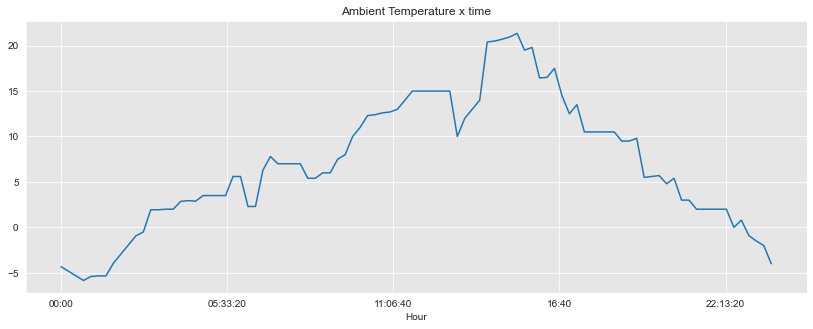

In [7]:
#Create the HVAC System
steel_plant.tbs.create_hvac(id="HVAC",desc="This is a HVAC System of the KMU",
                    space_area=500,heat_loss_coeff=0.3,thermal_capacity=16500,t_set_min=19.5,t_set=20,t_set_max=20.5)

df_aux = pd.read_excel(path+'\modelled_smes\steel_plant\model_inputs\pv_radiation.xlsx')

ax = df_aux.plot(x="Hour", y="T_amb", legend=False)
ax.set_title("Ambient Temperature x time")
plt.show()

steel_plant.tbs.hvac.t_amb = list(df_aux["T_amb"])

### Energy Systems (ES)
ES of the SME comprises of on-site energy generation and storage resources. This include electricity provision from locally installed renewable generation such  as **photovoltaic (PV)** and Wind, **Combined Heat and Power (CHP)** plants, **Diesel Generator (DGs)** and **Battery Energy Storage (BES)**.

#### Battery Energy Storage (BES)
BES aim to reduce the grid burden and utilize peak-shaving. The amount of energy of BESS at time step t can be given as:
$$E_{batt}(t+1) = E_{batt}(t)+\Bigg{(}p_{ch}(t)\eta_{ch}-\frac{p_{disch}(t)}{\eta_{disc}}\Bigg{)}\delta_{t}$$
where $E_{batt}$ represent the energy content of the battery at time step t, which is dependent on the control inputs $p_{ch}$ and $p_{disch}$, showing charging and discharging of the battery. $\eta_{ch}$ and $\eta_{disch}$ are the charging and discharging efficiences of the battery. In order to prevent the battery from both charging and discharging simultaneously a binary variable $Y_{batt}$ is introduced and following constraint can be written,
$$ P_{ch}(t) \le P_{ch}^{max}Y_{batt}(t) $$
$$ P_{disch}(t) \le P_{disch}^{max}\big{(}1-Y_{batt}(t)\big{)} $$
The energy produced can be either used or sold back to the grid. During each slot, the energy content of the battery shall lie in required State-of-Charge limits as $E_{batt}SOC_{min}\le E_{batt} \le E_{batt}SOC_{max} $.
<font size="2">
```python
    # Add the battery varaibles
    E_batt = mdl.addVars(len(K), vtype=GRB.CONTINUOUS, name="E_batt")
    p_batt_ch = mdl.addVars(len(K), vtype=GRB.CONTINUOUS, lb=0, ub=p_ch_max, name="p_batt_ch")
    p_batt_disch = mdl.addVars(len(K), vtype=GRB.CONTINUOUS, lb=0, ub=p_ch_max, name="p_batt_disch")
    p_batt_use = mdl.addVars(len(K), vtype=GRB.CONTINUOUS, name="p_batt_use")
    p_batt_sold = mdl.addVars(len(K), vtype=GRB.CONTINUOUS, name="p_batt_sold")
    # Binary variable for controlling switching between charging and discharging
    y_batt = mdl.addVars(len(K), vtype=GRB.BINARY, name="Y_ess_t")

    # Add the Battery Constraints
    if mode == "MILP":
        mdl.addConstrs(E_batt[t] == (self.es.ess["Batt_1"]["kwh_max"] * self.es.ess["Batt_1"]["initial_soc"])
                       for t in K if t == 0)
    elif mode == "MPC":
        mdl.addConstrs(E_batt[t] == x_o['E_batt_t'] for t in K if t == 0)

    mdl.addConstrs(E_batt[t + 1] == E_batt[t] + (p_batt_ch[t] * self.es.ess["Batt_1"]["charge_efficiency"] -p_batt_disch[t] / self.es.ess["Batt_1"]["discharge_efficiency"])*(self.sim_time_step / 60) for t in K if t < len(K) - 1)

    mdl.addConstrs(E_batt[t] >= e_batt_min for t in K)
    mdl.addConstrs(E_batt[t] <= e_batt_max for t in K)
    mdl.addConstrs(p_batt_ch[t] <= (self.es.ess["Batt_1"]["charging_rate_max"] * y_batt[t]) for t in K)
    mdl.addConstrs(p_batt_disch[t] <= (self.es.ess["Batt_1"]["discharge_rate_max"] * (1 - y_batt[t])) for t in K)

    # Battery Ramping Constraints
    mdl.addConstrs(p_batt_ch[t - 1] - p_batt_ch[t] <= 10 for t in K if t > 0)
    mdl.addConstrs(p_batt_ch[t - 1] - p_batt_ch[t] >= -10 for t in K if t > 0)
    mdl.addConstrs(p_batt_disch[t - 1] - p_batt_disch[t] <= 10 for t in K if t > 0)
    mdl.addConstrs(p_batt_disch[t - 1] - p_batt_disch[t] >= -10 for t in K if t > 0)
    mdl.addConstrs(p_batt_use[t] + p_batt_sold[t] == p_batt_disch[t] for t in K)
```
</font>

In [8]:
# Create the Energy System of the SME
steel_plant.create_es(id="KW_LAHR_ES",desc="This is the ES Object of the SME")

# Create the ESS
steel_plant.es.create_ess(id="Batt_1", kwh_max=300, initial_soc=0.1, charging_rate_max=75, charge_efficiency=1,
                     soc_min=0.01,soc_max=0.95,discharge_rate_max=75, discharge_efficiency=1)

#### Combined Heat and Power (CHP)
A CHP unit can deliver both heat and electricity output and can also be integrated in main ES systems of SME to provide the additional output, when flexbility in terms of power reduction is required.
$$ P_{CHP}(t)=f_{nom}\eta_{ele}\big{(}1-\eta_{ele}^{loss}\big{)} $$
$$ Q_{CHP}(t)=f_{nom}\eta_{heat}\big{(}1-\eta_{heat}^{loss}\big{)} $$
where $f_{nom}$ is the nominal output and $\eta$ the respective electricity and heat ratios of the plant. Note that the electricity produced from CHP plant can be used by the SME or it can be sold to the grid. Also, operation of CHP incurs the fuel cost, which can be written as,
$$ Cost_{CHP}(t) = \sum_{t}^{T}f_{nom}\lambda_{fuel}\Delta_{t} $$
code:
<font size="2">
```python
    # CHP Varibles
    p_chp = mdl.addVars(len(K),  vtype=GRB.CONTINUOUS, name='p_chp_', lb=0)
    p_chp_use = mdl.addVars(len(K),  vtype=GRB.CONTINUOUS, name='p_chp_use')
    p_chp_sold = mdl.addVars(len(K), vtype=GRB.CONTINUOUS, name='p_chp_sold')
    q_chp_in = mdl.addVars(len(K),  vtype=GRB.CONTINUOUS, name='q_chp', lb=0)
    N_chp = mdl.addVars(len(K),  vtype=GRB.BINARY, name="N_chp")
    chp_on = mdl.addVars(len(K), vtype=GRB.BINARY, name="chp_on")
    chp_off = mdl.addVars(len(K),  vtype=GRB.BINARY, name="chp_off")

    chp_cost = mdl.addVars(len(K),  vtype=GRB.CONTINUOUS, name="chp_cost")

    mdl.addConstrs(q_chp_in[t] == self.es.chp["CHP_1"]["q_nom"] * (N_chp[t] * (self.es.chp["CHP_1"]["n_heat"]))for t in K)
    mdl.addConstrs(p_chp[t] == self.es.chp["CHP_1"]["p_nom"] * (N_chp[t] * (self.es.chp["CHP_1"]["n_elec"]))for t in K)
    mdl.addConstrs(p_chp_use[t] + p_chp_sold[t] == p_chp[t] for t in K)
    mdl.addConstrs(chp_cost[t] == self.es.chp["CHP_1"]["fuel_cost"] * self.es.chp["CHP_1"]["f_nom"] * N_chp[t]
                   * (self.sim_time_step / 60 )for t in K)

    mdl.addConstr(quicksum(N_chp[t] for t in K) <=24)

    # #MR, MO and No. of switching of the CHP
    mdl.addConstrs(N_chp[t]-N_chp[t-1] == chp_on[t] -chp_off[t] for t in K if t>0)
    mdl.addConstrs(chp_on[t]+chp_off[t] <=1 for t in K)

    #MR
    for t in K:
        if t-3+1 >0:
            MR = list(range(t-3+1,t))
            mdl.addConstr(quicksum(chp_on[j] for j in MR ) <=N_chp[t])
        if t-6+1 >0:
            MO = list(range(t-6+1,t))
            mdl.addConstr(quicksum(chp_off[j] for j in MO ) <=N_chp[t])
```
</font>

In [9]:
#Create the CHP Plant
steel_plant.es.create_chp(id='CHP_1',f_nom=20.5,p_nom=5.5,q_nom=12.5,n_heat=0.9,n_ele=0.9,fuel_cost=0.05,storage_capacity=75,
                      storage_capacity_max=0.95,storage_capacity_min=0.35,soc_ini =0.01, t_on=45,t_off=30,chp_on_past=[0,0,1],
                      n_switches=50,storage_loss_factor=0.0534)

#### Diesel Generator
1. *Output Power*\
$$ P_{out}[t] = n_{dg}[t].P_{nom}.N_{dg}[t] $$\
where $n_{dg}$ is the power factor which the generator is running and $P_{nom}$ the nominal power given in kVA. $N_{dg}$ defines either the generator is running or not (binary variable).

2. *Fuel Consumption*\
$$ F_{cons}[t]= \Big{(}A_{G}.P_{out}[t]+B_{G}.P_{nom}[t]\Big{)}N_{dg}[t]$$\
where $A_{G}$ and $B_{G}$ are coefficients of the consumtion curve, given in $\frac{l}{kWh}$.

3. *Cost*\
$$ Cost_{dg}[t] = \lambda_{fuel}.F_{cons}[t] $$\
where $\lambda_{fuel}$ is the fuel cost (gasoline or diesel) in $\frac{€}{l}$. The following notebook describes the development of the above model.

4. *$CO_{2}$ Emission*
$$E_{rate}[t] = \lambda_{CO_2}.F_{cons}[t]$$\
where $\lambda_{CO_2}$ is the emission coefficient given in $\frac{kgCO_2}{l}$.

##### Model Constraints
* Power factor conform a range defined by the user $n_{min}<n_{dg}<n_{max}$, e.g between 30-90% of rated power.
* Output power is split into power that is used and power that can be sold. These two values are included in the power balance and costs/income of the plant. $P_{out}[t] = P_{dg_{use}}[t]+P_{dg_{sell}}[t]$

code
<font size="2">
```python
    def es_dg_opt_formulation(self, mdl, K):

        # Collecting parameters
        n_min = self.es.dg["DG-1"]["n_min"]
        n_max = self.es.dg["DG-1"]["n_max"]
        # e_max = self.es.dg["DG-1"]["e_max"]
        p_rated = self.es.dg["DG-1"]["p_rated"]
        cons_a = self.es.dg["DG-1"]["cons_a"]
        cons_b = self.es.dg["DG-1"]["cons_b"]
        e_coef = self.es.dg["DG-1"]["e_coef"]
        price_fuel = self.es.dg["DG-1"]["price_fuel"]

        # Add Diesel Generator variables
        p_dg_out = mdl.addVars(len(K),vtype=GRB.CONTINUOUS,lb=n_min*float(p_rated),ub=n_max*float(p_rated),name="p_dg_out")
        fuel_cons_dg = mdl.addVars(len(K),vtype=GRB.CONTINUOUS,name="fuel_cons_dg")
        e_dg_rate = mdl.addVars(len(K),vtype=GRB.CONTINUOUS,name="e_dg_rate")
        n_dg_gen = mdl.addVars(len(K),vtype=GRB.CONTINUOUS,lb=n_min,ub=n_max,name="n_dg_gen")
        N_dg = mdl.addVars(len(K),vtype=GRB.BINARY, name="N_dg")
        p_dg_use = mdl.addVars(len(K),vtype=GRB.CONTINUOUS,name="p_dg_use")
        p_dg_sold = mdl.addVars(len(K),vtype=GRB.CONTINUOUS, name="p_dg_sold")
        p_dg_cost = mdl.addVars(len(K),vtype=GRB.CONTINUOUS, name="p_dg_cost")

        # Add Constraints
        mdl.addConstrs(p_dg_out[t] == n_dg_gen[t]*p_rated*N_dg[t] for t in K)
        mdl.addConstrs(fuel_cons_dg[t] == (cons_a*p_dg_out[t]+cons_b*p_rated)*N_dg[t] for t in K)
        mdl.addConstrs(e_dg_rate[t] == e_coef*fuel_cons_dg[t] for t in K)
        mdl.addConstrs(p_dg_cost[t] == price_fuel*fuel_cons_dg[t] for t in K)
        mdl.addConstrs(p_dg_out[t] == p_dg_use[t]+p_dg_sold[t] for t in K)

        return p_dg_out, fuel_cons_dg, e_dg_rate,n_dg_gen, p_dg_sold, p_dg_use, p_dg_cost, N_dg
```
</font>

In [10]:
# #Create the Diesel Generator Class
steel_plant.es.create_dg(id="DG-1", p_rated=50,cons_a=0.246,cons_b=0.08145, price_fuel=0.1,
                         n_min = 0.3, n_max=1, e_coef=3.5)

#### Photovoltaic Systems (PV)
If the industry has n number of PV plants then, the total generation could be written as,
$$ P_{PV}(t) = \sum_{n}^{N}P_{peak}GF $$
where GF is the generator factor. As the other ES systems, the electricity produced can be either used or sold to the grid.
<font size="2">
```python
    # Get the total PV production
    pv_prod = np.zeros(len(self.es.pv_radiation_data)) # changed from sme_load_profiles  to es.pv_radiation_data
    pv_plants = list(self.es.pv_plants.keys())
    for pv in pv_plants:
        pv_prod = pv_prod + np.array(self.es.pv_plants[pv]["p_kw"])

    # %% PV Plant Variables
    p_pv_use = mdl.addVars(len(K), vtype=GRB.CONTINUOUS, name="p_pv_use")
    p_pv_sold = mdl.addVars(len(K), vtype=GRB.CONTINUOUS, name="p_pv_sold")

    # %% DER constraints
    if mode == "MILP":
        mdl.addConstrs(p_pv_use[t] + p_pv_sold[t] == pv_prod[t] for t in K)
    elif mode == "MPC":
        mdl.addConstrs(p_pv_use[t] + p_pv_sold[t] == pv_prod[t+n] for t in K)
```
</font>

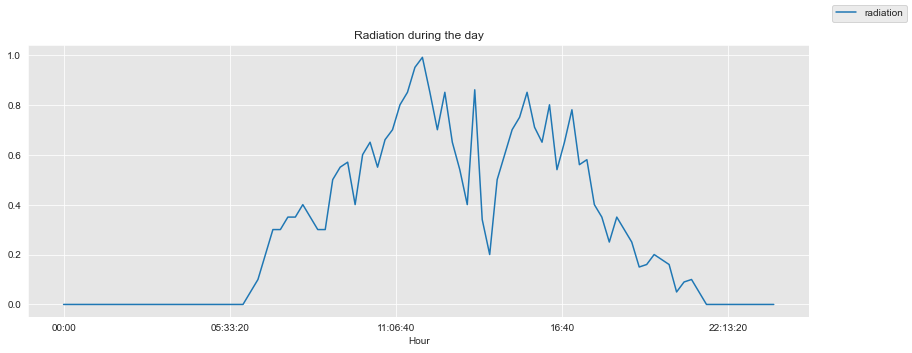

In [11]:
#get the pv radiation data
steel_plant.es.get_pv_radiation_data(file_path=path+'\modelled_smes\steel_plant\model_inputs\pv_radiation.xlsx')
#Create the PV plants
steel_plant.es.create_pv(id="PV_1",p_rated=50)

# Loading Profiles for HVAC and PV
df_aux = pd.read_excel(path+'\modelled_smes\steel_plant\model_inputs\pv_radiation.xlsx')

ax = df_aux.plot(x="Hour", y="radiation", legend=False)
ax.figure.legend()
ax.set_title("Radiation during the day")
plt.show()

### Market

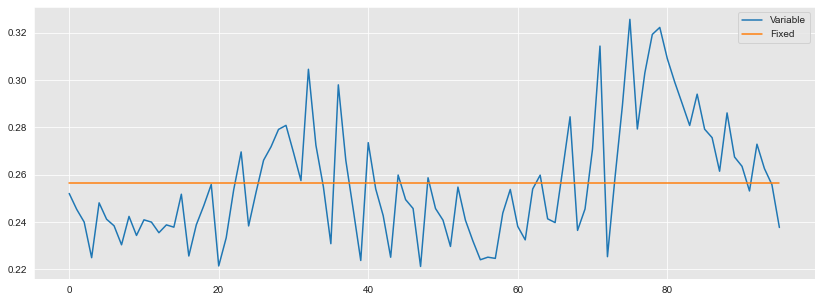

In [12]:
t_hr = [t for t in steel_plant.hr]  # time step in hr
T = steel_plant.N_sim  # time step in 0,1,2,3,..
K = T

#Create the market of the SME
steel_plant.create_market(id="M-01",type="Fixed",desc="Fixed Price",price_buy=3,price_sell=2,
                         electiricity_tax=2.05,demand_rate=141.62,energy_rate=0.45,eeg_surcharge=6.5,kwk_surcharge=5,
                         offshore_surcharge=0.049,abschalt_surcharge=0.011,tax=19,pltw=[24,36],retailer_cut_da=10)

steel_plant.get_day_ahead_prices(file_path=path+"/external_model_inputs/market_price.xlsx",index_with_agent=False,n_days=1)
steel_plant.get_capacity_prices(file_path=path+"/external_model_inputs/market_price.xlsx",index_with_agent=False,n_days=1)

# Get day ahead prices
prices_original = pd.read_excel(path+'\modelled_smes\steel_plant\model_inputs\market_price.xlsx')
prices = (prices_original["price"]/1000).to_list()
steel_plant.day_ahead_prices = prices

# Get market information
market = steel_plant.markets["M-01"]
participation_mechanism = "Day_ahead"

p_fix = (market.electiricity_tax + market.eeg_surcharge + market.abschalt_surcharge + market.kwk_surcharge + market.kwk_surcharge)/100
tax = market.tax/100

market.prices_variable["Price"] = [(x+p_fix)*(1+tax) for x in steel_plant.day_ahead_prices]
market.prices_fixed["Price"] = [(market.price_buy/100+p_fix)*(1+tax)]*len(K)

ax= market.prices_variable["Price"].plot(label="Variable")
ax2=market.prices_fixed["Price"].plot(label="Fixed")
plt.legend()

### Control System
The overall objective here is reduce the electricity and operational costs incurred and increase the revenue in case of additional export or providing the flexibility. The power balance and the power sold of the SME can be written as,
$$ P_{grid}(t) = P_{MFS}(t)+P_{PCS}(t)+P_{PHS}(t)-\big{(}P_{PV}(t)+P_{CHP}(t)+P_{batt}(t)\big{)} $$
$$ P_{grid}^{sold}(t) = P_{PV}^{sold}(t)+P_{CHP}^{sold}(t)+P_{batt}^{sold}(t) $$ 
Most of the times it would required to limit the power intake to $L_{1}$ or feed-in to the grid $L_{2}$, which is formulated as follows,
$$ P_{grid}^{buy}(t) \le L_{1}Y_{grid}(t) $$
$$ P_{grid}^{sell}(t) \le L_{2}(1-Y_{grid}(t)) $$
where $Y_{grid}$ represents a binary variable which ensures that both intake and feed-in of power does not happen simultaneously.
<font size="2">
```python
        # SME Load Demand
        demand_kw = mdl.addVars(len(K), vtype=GRB.CONTINUOUS, name="demand_kw")

        #Energy/Power Management
        mdl.addConstrs(demand_kw[t] == p_cas_t[t] + p_mfs_t[t] + p_pcs_t[t] for t in K) #why it was p_cas_t twice????

        #Power Balance
        mdl.addConstrs(p_grid[t] + p_batt_use[t] + p_pv_use[t] + p_chp_use[t] + p_dg_use[t] == demand_kw[t] + p_batt_ch[t] for t in K) 

        #Total power injected into the Grid
        mdl.addConstrs(p_grid_sold[t] == p_batt_sold[t] + p_pv_sold[t] + p_chp_sold[t] + p_dg_sold[t] for t in K)
        # Power transaction constraints
        mdl.addConstrs(p_grid[t] <= L1 * (y_grid[t]) for t in K)
        mdl.addConstrs(p_grid_sold[t] <= L2 * (1 - y_grid[t]) for t in K)
```
</font>


#### ADD text explaining fixed price, capacity and day ahead participation methods

The overall objective function is:
$$min J = \sum_{t}\Big{(}P_{grid}^{buy}(t)\lambda_{buy}(t)-P_{grid}^{buy}(t)\lambda_{buy}(t)+f_{nom}\lambda_{CHP}^{fuel}\Big{)}\Delta_{t}$$
<font size="2">
```python
        # Objective function
        if participation_mechansim == "Fixed":
            mdl.setObjective(quicksum(p_grid[t] * (c_buy) * (self.sim_time_step / 60)  for t in K))

        elif participation_mechansim == "Day_ahead":
            mdl.setObjective(quicksum((p_grid[t] * (prices[t]) * (self.sim_time_step / 60)) - (p_grid_sold[t] * c_sell * (self.sim_time_step / 60)) for t in K) + quicksum(chp_cost[t] for t in T) + quicksum(p_dg_cost[t] for t in K))

        elif participation_mechansim == "Capacity":
            t0 = flex_interval[0]
            t1 = flex_interval[1] + 1
            interval = list(range(t0, t1))

            y1 = mdl.addVars(len(T), vtype=GRB.CONTINUOUS, name="Y1")
            y2 = mdl.addVars(len(T), vtype=GRB.CONTINUOUS,name="Y2")
            y3 = mdl.addVars(len(T), vtype=GRB.CONTINUOUS,name="Y3")

            #calculation of the difference between Pgrid and Ptarget
            mdl.addConstrs(y1[t] == p_grid[t] - p_target for t in interval)

            #Taking the absoulte of the (Pgrid-Ptarget)
            mdl.addConstrs(y2[t] ==  abs_(y1[t]) for t in interval)

            #Finding the factors --> (1-abs(Pgrid-Ptarget)/Ptarget)
            mdl.addConstrs(y3[t] == 1-(y2[t]/p_target) for t in interval)

            mdl.setObjective(quicksum(p_grid[t] * (c_buy) * (self.sim_time_step / 60)  for t in K)-
                             quicksum(y3[t]*0.8*15/60 for t in interval))
```
</font>


--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-07-10
Using license file C:\Users\guilh\gurobi.lic



 MFS OPTIMIZATION DONE 



Changed value of parameter MIPGap to 1.0
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 19082 rows, 17282 columns and 47185 nonzeros
Model fingerprint: 0xad1c60bd
Variable types: 9504 continuous, 7778 integer (6818 binary)
Coefficient statistics:
  Matrix range     [5e-05, 1e+03]
  Objective range  [6e-02, 1e+00]
  Bounds range     [1e+00, 1e+05]
  RHS range        [8e-03, 3e+03]
Presolve removed 14187 rows and 11530 columns
Presolve time: 0.12s
Presolved: 4895 rows, 5752 columns, 20877 nonzeros
Variable types: 1310 continuous, 4442 integer (3706 binary)

Root relaxation: objective 9.459268e+02, 434

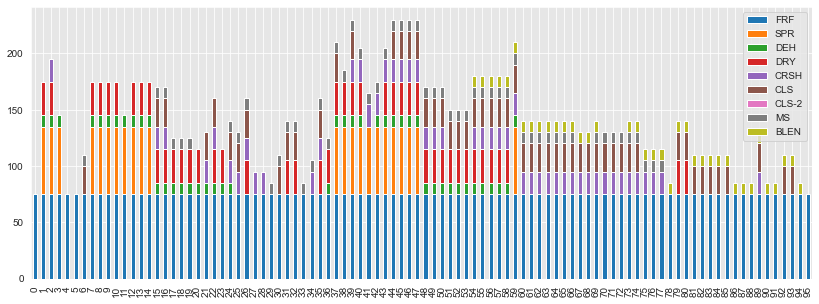

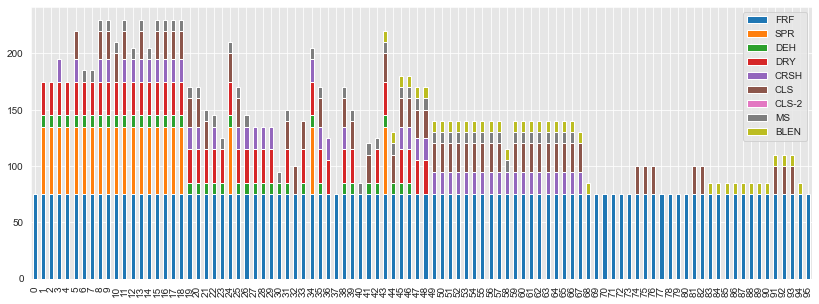

In [13]:
# Perform the MILP Optimization with MFS
machines_run_fix,results_power_fix,results_input_variables_fix,results_state_varaibes_fix,results_es_fix,results_costs_fixed  = \
steel_plant.opt_milp(show_figure=False,L1=1000,L2=0,c_buy=0.30,c_sell=0.3,flex_interval=[0,20],market_id="M-01",
                      participation_mechansim="Fixed",p_target=200,cas_opt=True,pcs_opt=True,phs_opt=True)

machines_run_var,results_power_var,results_input_variables_var,results_state_varaibes_var,results_es_var,results_costs_var = \
steel_plant.opt_milp(show_figure=False,L1=1000,L2=0,c_buy=0.30,c_sell=0.3,flex_interval=[0,20],market_id="M-01",
                      participation_mechansim="Day_ahead",p_target=200,cas_opt=True,pcs_opt=True,phs_opt=True,
                      dg_opt=False)


# Results

In [14]:
def plot_machine_runs(machines_run,results_power,size=[14, 5]):
    machines_run.index = pd.date_range("00:00","23:45",freq="15min")
    fig_mfs_fix = plt.figure() # Create matplotlib figure
    ax = machines_run.plot(kind="bar",stacked=True) # Create matplotlib axes
    ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.
    width = 0.4
    results_power["Electricity_price"].plot(ax=ax2,color="black",style="--",linewidth=1.5)
    ax.set_ylabel('Power - kW',fontsize=12)
    # Make most of the ticklabels empty so the labels don't get too crowded
    ticklabels = ['']*len(machines_run.index)
    # Every 4th ticklable shows the month and day
    ticklabels[::4] = [item.strftime('%H:%M') for item in machines_run.index[::4]]
    # Every 12th ticklabel includes the year
    ticklabels[::12] = [item.strftime('%H:%M') for item in machines_run.index[::12]]
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
    plt.gcf().autofmt_xdate()
    ax.legend()
    ax.set_xlabel("Time in Hours",fontsize=12)
    ax2.set_ylabel("Electricity cost in €/kWH",fontsize=12)
    ax.legend(bbox_to_anchor=(1.1, 1), loc='upper left')
    ax.set_title("Load Profiles of operating machines inside MFS")
    plt.show()

## Load profiles
### Fixed Price

<Figure size 1008x360 with 0 Axes>

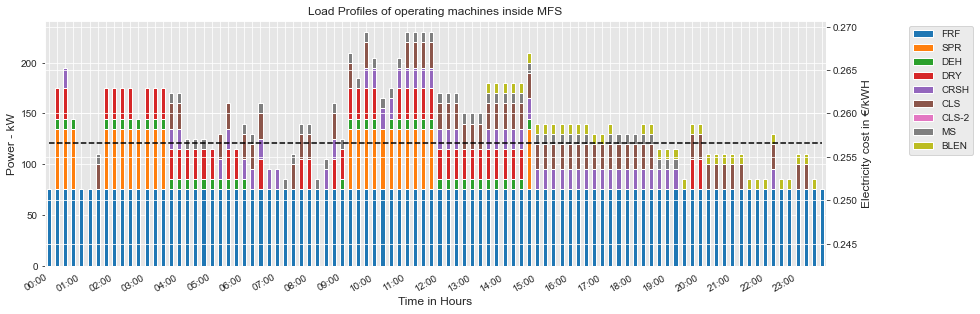

In [15]:
plot_machine_runs(machines_run_fix,results_power_fix)

### Variable Prices

<Figure size 1008x360 with 0 Axes>

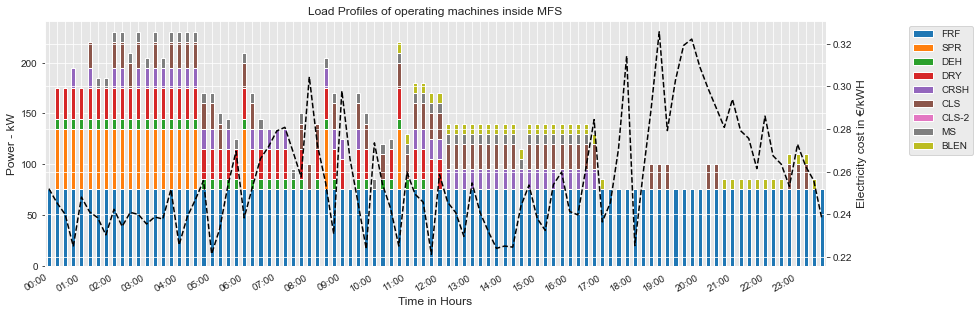

In [16]:
plot_machine_runs(machines_run_var,results_power_var)

## Results - Technical Building Services (TBS)
### Control Variables

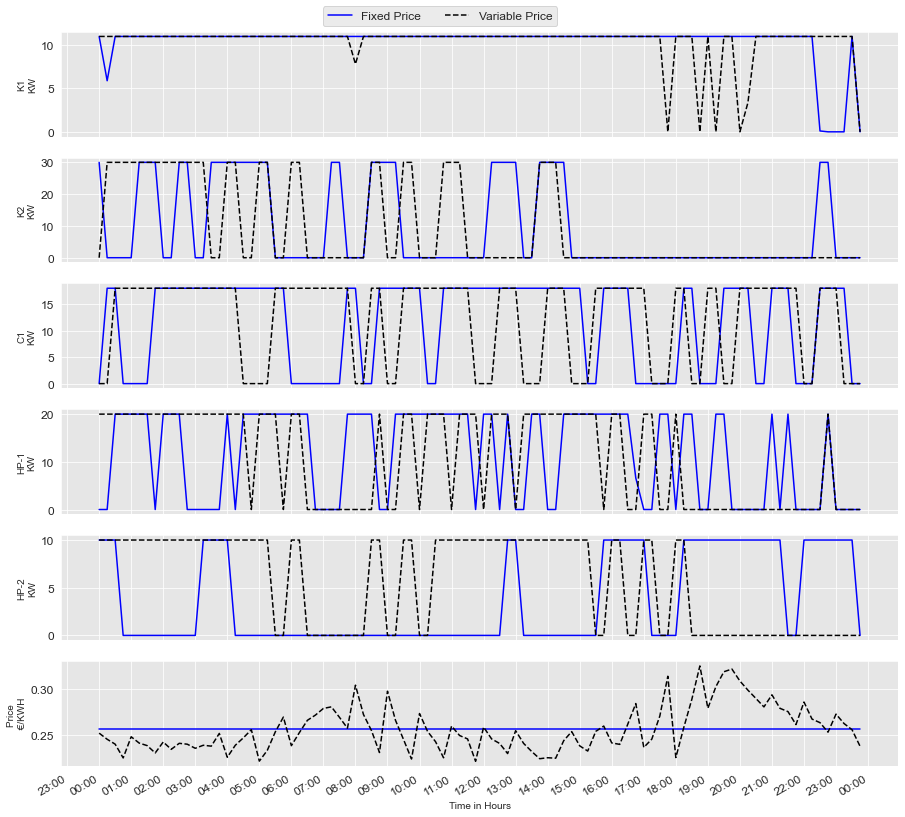

In [23]:
#%%Plot the Input variables
font_size = 10
matplotlib.rc('xtick', labelsize=1.2*font_size)
matplotlib.rc('ytick', labelsize=1.2*font_size)
plt.rcParams['figure.figsize'] = [15, 15]
fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(6,sharex=True)
x = pd.date_range("00:00","23:45",freq="15min")

ax1.set_ylabel('K1\nKW',fontsize=font_size)
ax1.plot(x, results_input_variables_fix["K1"],"b-",label="Fixed price",linewidth=1.5)
ax1.plot(x, results_input_variables_var["K1"],"k--",label="Variable price",linewidth=1.5)
ax.xaxis.labelpad = 5

ax2.set_ylabel('K2\nKW',fontsize=font_size)
ax2.plot(x, results_input_variables_fix["K2"],"b-",label="Fixed price",linewidth=1.5)
ax2.plot(x, results_input_variables_var["K2"],"k--",label="Variable price",linewidth=1.5)

ax3.set_ylabel('C1\nKW',fontsize=font_size)
ax3.plot(x, results_input_variables_fix["Chiller-01"],"b-",label="Vair,in-Fixed price")
ax3.plot(x, results_input_variables_var["Chiller-01"],"k--",label="Variable price",linewidth=1.5)

ax4.set_ylabel('HP-1\nKW',fontsize=font_size)
ax4.plot(x, results_input_variables_fix["HP-1"],"b-",label="Vair,in-Fixed price")
ax4.plot(x, results_input_variables_var["HP-1"],"k--",label="Variable price",linewidth=1.5)

ax5.set_ylabel('HP-2\nKW',fontsize=font_size)
ax5.plot(x, results_input_variables_fix["HP-2"],"b-",label="Vair,in-Fixed price")
ax5.plot(x, results_input_variables_var["HP-2"],"k--",label="Variable price",linewidth=1.5)

# Format the x axis
ax6.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax6.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax6.set_ylabel('Price \n €/KWH',fontsize=font_size)
ax6.set_xlabel("Time in Hours",fontsize=font_size)
ax6.plot(x, results_input_variables_fix["Electricity_price"],"b-",label="Fixed Price",linewidth=1.5)
ax6.plot(x, results_input_variables_var["Electricity_price"],"k--",label="Variable Price",linewidth=1.5)

handles, labels = ax6.get_legend_handles_labels()
plt.legend(bbox_to_anchor=(0.6, 7.3),ncol=2,fontsize=1.2*font_size)

plt.gcf().autofmt_xdate()
plt.show()

### States variables

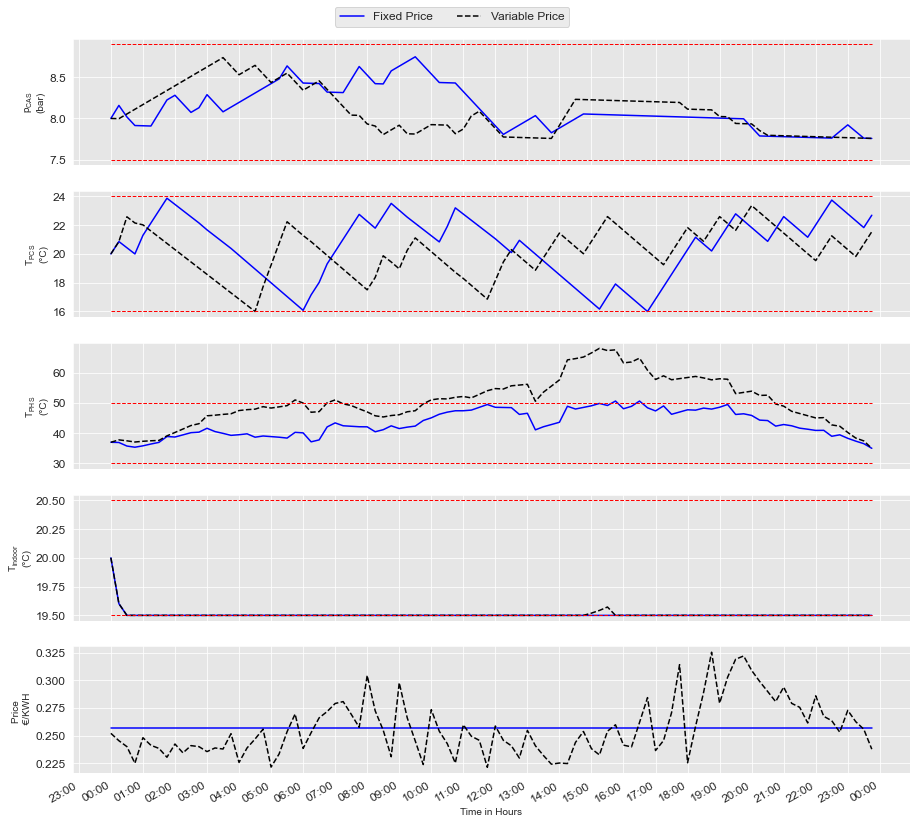

In [18]:
#%% Plot the State Variables
params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,sharex=True)
x =  pd.date_range("00:00","23:45",freq="15min")

ax1.set_ylabel('$p_{CAS}$\n(bar)',fontsize=font_size)
ax1.plot(x, results_state_varaibes_fix["p_t"],"b-",label="Fixed price",linewidth=1.5)
ax1.plot(x, results_state_varaibes_var["p_t"],"k--",label="Variable price",linewidth=1.5)
ax1.plot(x,[8.9]*len(x),"r--",linewidth=1)
ax1.plot(x,[7.5]*len(x),"r--",linewidth=1)

ax2.set_ylabel('$T_{PCS}$\n(°C)',fontsize=font_size)
ax2.plot(x, results_state_varaibes_fix["Ts_pcs"],"b-",label="Fixed price",linewidth=1.5)
ax2.plot(x, results_state_varaibes_var["Ts_pcs"],"k--",label="Variable price",linewidth=1.5)
ax2.plot(x,[steel_plant.tbs.pcs.storages["s_cws"]["temp_min"]]*len(x),"r--",linewidth=1)
ax2.plot(x,[steel_plant.tbs.pcs.storages["s_cws"]["temp_max"]]*len(x),"r--",linewidth=1)

ax3.set_ylabel('$T_{PHS}$\n(°C)',fontsize=font_size)
ax3.plot(x, results_state_varaibes_fix["Ts_phs"],"b-",label="Fixed price",linewidth=1.5)
ax3.plot(x, results_state_varaibes_var["Ts_phs"],"k--",label="Variable price",linewidth=1.5)
ax3.plot(x,[30]*len(x),"r--",linewidth=1)
ax3.plot(x,[50]*len(x),"r--",linewidth=1)

ax4.set_ylabel('$T_{indoor}$\n(°C)',fontsize=font_size)
ax4.plot(x, results_state_varaibes_fix["Tr"],"b-",label="Fixed price",linewidth=1.5)
ax4.plot(x, results_state_varaibes_var["Tr"],"k--",label="Variable price",linewidth=1.5)
ax4.plot(x,[steel_plant.tbs.hvac.t_set_min]*len(x),"r--",linewidth=1)
ax4.plot(x,[steel_plant.tbs.hvac.t_set_max]*len(x),"r--",linewidth=1)

# Format the x axis
ax5.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax5.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax5.set_ylabel('Price \n €/KWH',fontsize=font_size)
ax5.set_xlabel("Time in Hours",fontsize=font_size)
ax5.plot(x, results_input_variables_fix["Electricity_price"],"b-",label="Fixed Price",linewidth=1.5)
ax5.plot(x, results_input_variables_var["Electricity_price"],"k--",label="Variable Price",linewidth=1.5)
handles, labels = ax5.get_legend_handles_labels()
plt.legend(bbox_to_anchor=(0.6, 6.1),ncol=2,fontsize=1.2*font_size)

plt.gcf().autofmt_xdate()
plt.show()

## Results - Energy Systems (ES)

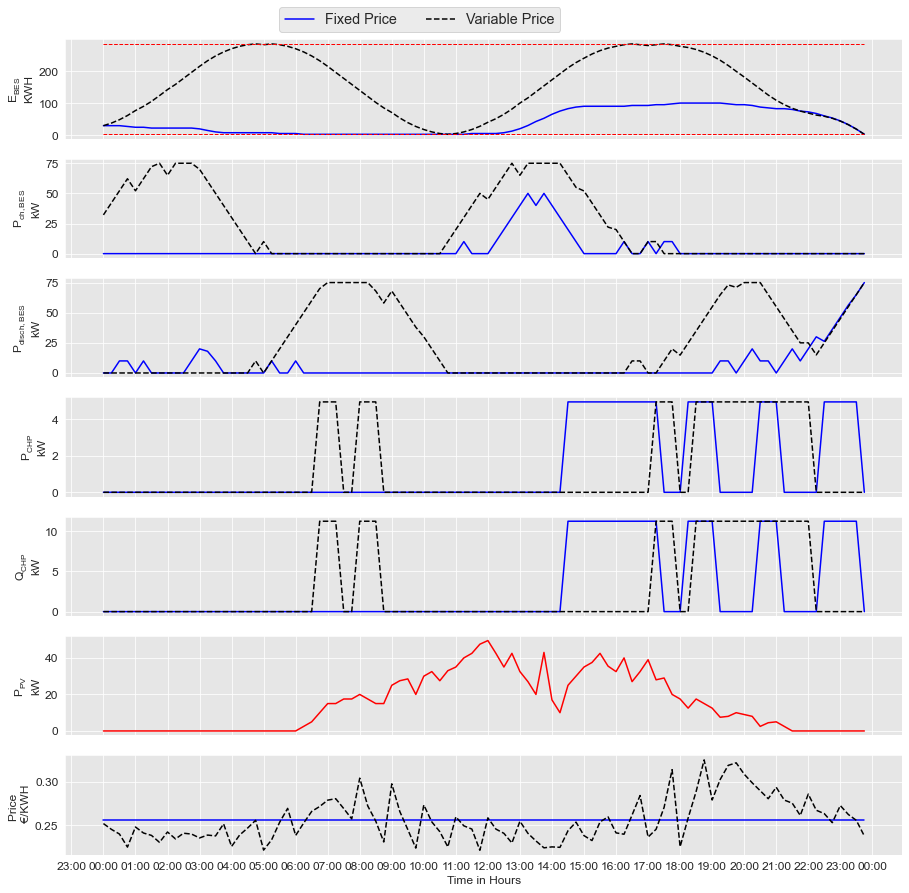

<Figure size 1080x1080 with 0 Axes>

In [19]:
#%% Plot the ES Systems
fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7) = plt.subplots(7,sharex=True)
x =  pd.date_range("00:00","23:45",freq="15min")
font_size = 12

ax1.set_ylabel('$E_{BES}$\nKWH',fontsize=font_size)
ax1.plot(x, results_es_fix["E_batt"],"b-",label="Fixed price",linewidth=1.5)
ax1.plot(x, results_es_var["E_batt"],"k--",label="Variable price",linewidth=1.5)
ax1.plot(x,[steel_plant.es.ess["Batt_1"]["soc_min"]*steel_plant.es.ess["Batt_1"]["kwh_max"]]*len(x),"r--",linewidth=1)
ax1.plot(x,[steel_plant.es.ess["Batt_1"]["soc_max"]*steel_plant.es.ess["Batt_1"]["kwh_max"]]*len(x),"r--",linewidth=1)


ax2.set_ylabel('$P_{ch,BES}$\nkW',fontsize=font_size)
ax2.plot(x, results_es_fix["P_batt_ch"],"b-",label="Fixed price",linewidth=1.5)
ax2.plot(x, results_es_var["P_batt_ch"],"k--",label="Variable price",linewidth=1.5)

ax3.set_ylabel('$P_{disch,BES}$\nkW',fontsize=font_size)
ax3.plot(x, results_es_fix["P_batt_disch"],"b-",label="Fixed price",linewidth=1.5)
ax3.plot(x, results_es_var["P_batt_disch"],"k--",label="Variable price",linewidth=1.5)

ax4.set_ylabel('$P_{CHP}$\nkW',fontsize=font_size)
ax4.plot(x, results_es_fix["CHP_elec"],"b-",label="Fixed price",linewidth=1.5)
ax4.plot(x, results_es_var["CHP_elec"],"k--",label="Variable price",linewidth=1.5)

ax5.set_ylabel('$Q_{CHP}$\nkW',fontsize=font_size)
ax5.plot(x, results_es_fix["CHP_q"],"b-",label="Fixed price",linewidth=1.5)
ax5.plot(x, results_es_var["CHP_q"],"k--",label="Variable price",linewidth=1.5)

ax6.set_ylabel('$P_{PV}$\nkW',fontsize=font_size)
ax6.plot(x, results_es_fix["P_PV"],"r-")

# Format the x axis
ax7.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax7.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax7.set_ylabel('Price \n €/KWH',fontsize=font_size)
ax7.set_xlabel("Time in Hours",fontsize=font_size)
ax7.plot(x, results_es_fix["Electricity_price"],"b-",label="Fixed Price",linewidth=1.5)
ax7.plot(x, results_es_var["Electricity_price"],"k--",label="Variable Price",linewidth=1.5)

handles, labels = ax7.get_legend_handles_labels()
plt.legend(bbox_to_anchor=(0.6, 8.6),ncol=2,fontsize=1.2*font_size)


plt.show()
plt.gcf().autofmt_xdate()

## Results - Overall Load Profile, flexibility assessment and cost comparison
### Load profile, power exchange with the grid and flexbility

In [25]:
# #%% Plot the Flexibility Profiles
# import numpy as np
# fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(6,sharex=True)
# #x = steel_plant.sme_load_profiles.index.strftime("%H:%M")
# x = pd.date_range("00:00","23:45",freq="15min")
# axes_limit = [-240,240]


# ax1.set_ylabel('$P_{Grid}$\nKW',fontsize=font_size)
# y = np.array(results_power_fix["P_Grid"]-results_power_var["P_Grid"])
# mask1 = y <0
# mask2 = y >= 0
# ax1.bar(x[mask1], y[mask1], color="red",label="Negative Flexibility")
# ax1.bar(x[mask2], y[mask2], color="blue",label="Positive Flexibility")
# ax1.set_ylim(axes_limit)


# ax2.set_ylabel('$P_{CAS}$\nKW',fontsize=font_size)
# y = np.array(results_power_fix["P_CAS"]-results_power_var["P_CAS"])
# mask1 = y <0
# mask2 = y >= 0
# ax2.bar(x[mask1], y[mask1], color="red",label="Negative Flexibility")
# ax2.bar(x[mask2], y[mask2], color="blue",label="Positive Flexibility")
# ax2.set_ylim(axes_limit)

# ax3.set_ylabel('$P_{PCS}$\nKW',fontsize=font_size)
# y = np.array(results_power_fix["P_PCS"]-results_power_var["P_PCS"])
# mask1 = y <0
# mask2 = y >= 0
# ax3.bar(x[mask1], y[mask1], color="red",label="Negative Flexibility")
# ax3.bar(x[mask2], y[mask2], color="blue",label="Positive Flexibility")
# ax3.set_ylim(axes_limit)

# ax4.set_ylabel('$P_{PHS}$\nKW',fontsize=font_size)
# y = np.array(results_power_fix["P_PHS"]-results_power_var["P_PHS"])
# mask1 = y <0
# mask2 = y >= 0
# ax4.bar(x[mask1], y[mask1], color="red",label="Negative Flexibility")
# ax4.bar(x[mask2], y[mask2], color="blue",label="Positive Flexibility")
# ax4.set_ylim(axes_limit)

# ax5.set_ylabel('P_Batt\nKW',fontsize=font_size)
# #Calculation P_battery
# P_batt_fixed = results_es_fix["P_batt_ch"]-results_es_fix["P_batt_disch"]
# P_batt_var = results_es_var["P_batt_ch"]-results_es_var["P_batt_disch"]
# y = np.array(P_batt_fixed-P_batt_var)
# mask1 = y <0
# mask2 = y >= 0
# ax5.bar(x[mask1], y[mask1], color="red",label="Negative Flexibility")
# ax5.bar(x[mask2], y[mask2], color="blue",label="Positive Flexibility")
# ax5.set_ylim(axes_limit)

# ax6.set_ylabel('Price \n €/KWH',fontsize=font_size)
# ax6.set_xlabel("Time steps",fontsize=font_size)
# ax6.plot(x, results_es_fix["Electricity_price"],"b-",label="Fixed Price",linewidth=1.5)
# ax6.plot(x, results_es_var["Electricity_price"],"k--",label="Variable Price",linewidth=1.5)
# handles, labels = ax6.get_legend_handles_labels()
# fig.legend(handles=handles, labels=labels, loc='upper center',fontsize=font_size,ncol=2)
# plt.gcf().autofmt_xdate()

# plt.show()

### Breakdown of the flexibility provided by each system

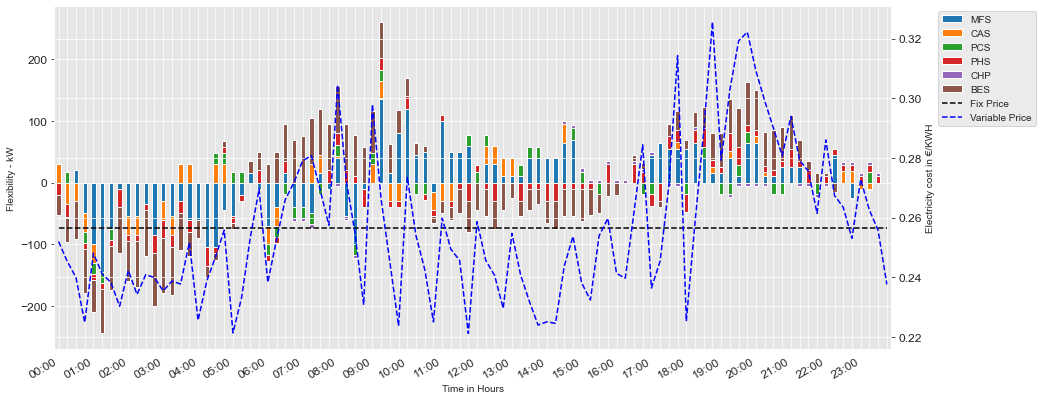

In [26]:
plt.rcParams['figure.figsize'] = [15, 7]
#%%Plot Flexibility Stacked Bar Plot
results_flex = pd.DataFrame(columns=["MFS","CAS","PCS","PHS","CHP","BES"])
results_flex["MFS"] = results_power_fix["P_MFS"]-results_power_var["P_MFS"]
results_flex["CAS"] = results_power_fix["P_CAS"]-results_power_var["P_CAS"]
results_flex["PCS"] = results_power_fix["P_PCS"]-results_power_var["P_PCS"]
results_flex["PHS"] = results_power_fix["P_PHS"]-results_power_var["P_PHS"]
results_flex["CHP"] = results_es_fix["CHP_elec"]-results_es_var["CHP_elec"]
results_flex["BES"] = (results_es_fix["P_batt_ch"]-results_es_fix["P_batt_disch"]) - \
                       (results_es_var["P_batt_ch"]-results_es_var["P_batt_disch"])
results_flex.index = x
fig_flex_mix = plt.figure() # Create matplotlib figure
ax = fig_flex_mix.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.
width = 0.4

results_flex.plot.bar(ax=ax,stacked=True)

results_power_fix["Electricity_price"].plot(ax=ax2,color="black",style="--",linewidth=1.5,label="Fix Price")
results_power_var["Electricity_price"].plot(ax=ax2,color="blue",style="--",linewidth=1.5,label="Variable Price")



ticklabels = ['']*len(machines_run_var.index)
# Every 4th ticklable shows the month and day
ticklabels[::4] = [item.strftime('%H:%M') for item in machines_run_var.index[::4]]
# Every 12th ticklabel includes the year
ticklabels[::12] = [item.strftime('%H:%M') for item in machines_run_var.index[::12]]
ax2.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
plt.gcf().autofmt_xdate()
ax.set_ylabel('Flexibility - kW')
ax2.set_ylabel("Electricity cost in €/KWH")
ax.set_xlabel("Time in Hours")
#Legends
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()
